### Check resilience of the sequence

In [33]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost, spin, mN = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5], mol[:,4], mol[:,3]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0) & (spin == 0) & (mN == 1)
    raw = int(cp.count_nonzero(mask).get())
    return raw

In [4]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks
seq_ori_XY = cp.tile(original_gpu[0], (10, 1))
seq_ori_XYZ1 = cp.tile(original_gpu[1], (5, 1))
seq_ori_XYZ2 = cp.tile(original_gpu[2], (5, 1))
seq_ori_XYZ3 = cp.tile(original_gpu[3], (10, 1))
seq_ori_XYZ4 = cp.tile(original_gpu[4], (10, 1))


# Repeat each block along the first axis, then concatenate in order
blocks = [
    seq_ori_XY,  
    seq_ori_XYZ1,  
    seq_ori_XYZ2,  
    seq_ori_XYZ3,  
    seq_ori_XYZ4,  
]

seq_ori = cp.concatenate(blocks, axis=0)
seq_op = np.load("ga_runs/SEGIDX_20251108_221605/final_top5/top1_sequence.npy")

In [5]:
rabis = np.linspace(0.5, 1.5, 11)
print(rabis)

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]


In [6]:
temp = [25e-6, 25e-6, 25e-6]
scores_ori, scores_op = [], []
for rabi in rabis:
    mol_original = cr.build_thermal_molecules_gpu(10_000, temp)
    mol_optimized = cr.build_thermal_molecules_gpu(10_000, temp)

    cr.raman_cool_with_pumping(mol_original, seq_ori, res, show_progress=True, Rabi_scale=rabi)
    cr.raman_cool_with_pumping(mol_optimized, seq_op, res, show_progress=True, Rabi_scale=rabi)

    score_ori = score_sequence(mol_original)
    score_op = score_sequence(mol_optimized)

    scores_ori.append(score_ori)
    scores_op.append(score_op)
scores_ori = np.array(scores_ori)
scores_op = np.array(scores_op)

Raman pulses: 100%|██████████| 185/185 [00:33<00:00,  5.56it/s]


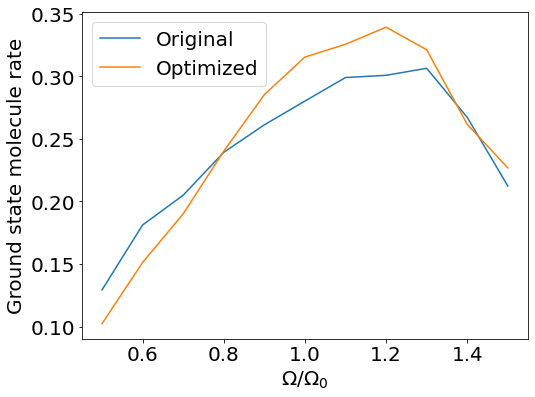

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(rabis, scores_ori/10_000, label='Original')
plt.plot(rabis, scores_op/10_000, label='Optimized')
plt.xlabel("$\Omega / \Omega_0$", fontsize=20)
plt.ylabel("Ground state molecule rate", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=20)

### n_bar survival plot

In [26]:
chunk_size = 10
chunks_ori = [seq_ori[i:i+chunk_size,:] for i in np.arange(0, len(seq_ori), chunk_size)]

In [34]:
res_ori = []
mol_ori = cr.build_thermal_molecules_gpu(10_000, temp)
for chunk in chunks_ori:
    cr.raman_cool_with_pumping(mol_ori, chunk, res, show_progress=True)
    result = cr.bootstrap_stats_from_molecules(mol_ori)
    res_ori.append(result)

Raman pulses: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


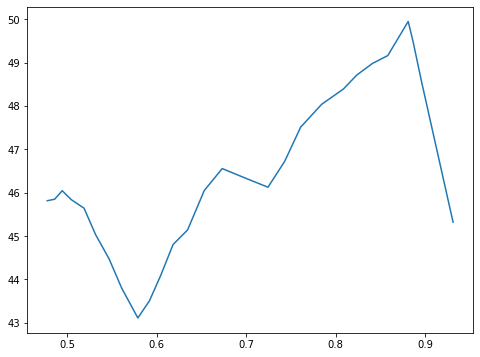

In [40]:
plt.figure(figsize=(8, 6))
plt.plot([r['survival_rate_mean'].get() for r in res_ori], [r['mot_mean'][2].get() for r in res_ori])

In [38]:
res_ori[0]

{'survival_rate_mean': array(0.931),
 'survival_rate_sem': array(7.97659383e-05),
 'mot_mean': array([ 3.33941998,  3.39366273, 45.31922664]),
 'mot_sem': array([0.00196332, 0.00224465, 0.01352145]),
 'ground_state_rate_mean': array(0.00220198),
 'ground_state_rate_sem': array(1.44774911e-05),
 'N': array(10000),
 'B': array(1000)}